<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Frameworks/Pytorch/RNNs/Simple/Name2Lang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [1]:
!ls
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


!mkdir -p drive
!google-drive-ocamlfuse drive

import os
os.chdir("drive/Udacity/RNN/")
!ls

sample_data
E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0

In [2]:
import torch
import numpy as np
from io import open
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import os, string, random, time, math
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

## Dataset

In [3]:
languages = []
data = []
X = []
Y = []

with open('name2lang.txt', 'r') as f: 
    for line in f:
        line = line.split(',')
        name = line[0].strip()
        lang = line[1].strip()
        if not lang in languages:
            languages.append(lang)
        X.append(name)
        Y.append(lang)
        data.append((name, lang))

In [4]:
n_languages = len(languages)
print(type(languages))
print(type(data))
print("Number of Languages : ",n_languages)
print(languages)

<class 'list'>
<class 'list'>
Number of Languages :  18
['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


In [5]:
for x,y in data[0:10]:
  print("Name is : ", x, " and Language is : ", y)

Name is :  Abreu  and Language is :  Portuguese
Name is :  Albuquerque  and Language is :  Portuguese
Name is :  Almeida  and Language is :  Portuguese
Name is :  Alves  and Language is :  Portuguese
Name is :  Araujo  and Language is :  Portuguese
Name is :  Araullo  and Language is :  Portuguese
Name is :  Barros  and Language is :  Portuguese
Name is :  Basurto  and Language is :  Portuguese
Name is :  Belo  and Language is :  Portuguese
Name is :  Cabral  and Language is :  Portuguese


## Train Test Split

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [7]:
print(len(X_train), len(X_test))

16040 4010


## Encoding names and language

In [8]:
all_letters = string.ascii_letters + " .,;'"
print(all_letters)
n_letters = len(all_letters)
print("Total characters are ", n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Total characters are  57


In [9]:
name = "Abreu"
rep = torch.zeros(len(name), 1, n_letters)
print(rep.shape)
for index, letter in enumerate(name):
        print(index, letter)
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
print(rep)

torch.Size([5, 1, 57])
0 A
1 b
2 r
3 e
4 u
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [10]:
def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [11]:
def lang_rep(lang):
    return torch.tensor([languages.index(lang)], dtype=torch.long)

In [12]:
print(name_rep('Abreu'))
print(lang_rep('Portuguese'))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

## Visualize Data

In [13]:
count = {}
for l in languages: 
    count[l] = 0

In [14]:
print(count)

{'Portuguese': 0, 'Irish': 0, 'Spanish': 0, 'Vietnamese': 0, 'Chinese': 0, 'Greek': 0, 'Czech': 0, 'Dutch': 0, 'Japanese': 0, 'French': 0, 'German': 0, 'Scottish': 0, 'English': 0, 'Russian': 0, 'Polish': 0, 'Arabic': 0, 'Korean': 0, 'Italian': 0}


In [15]:
for Name, Language in data:
    count[Language] += 1 

In [16]:
print(count)

{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


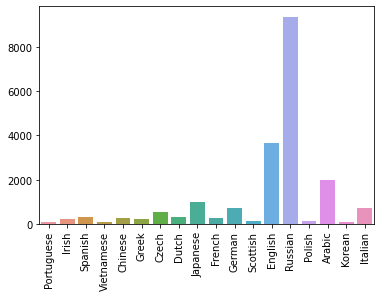

In [17]:
plt_ = sns.barplot(list(count.keys()), list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(), rotation=90)
plt.show()

## Model Class

In [18]:
class RNN_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_, hidden):      
        combined = torch.cat((input_, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [19]:
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages)
print(net)

RNN_net(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [20]:
net.eval()
name_ohe = name_rep("Anubhav")
hidden = net.init_hidden()
print(hidden.shape)
print(name_ohe.size())
print(name_ohe.size()[0])

torch.Size([1, 128])
torch.Size([7, 1, 57])
7


In [21]:
for i in range(name_ohe.size()[0]):
        output, hidden = net(name_ohe[i], hidden)
        print(output.shape,hidden.shape)

torch.Size([1, 18]) torch.Size([1, 128])
torch.Size([1, 18]) torch.Size([1, 128])
torch.Size([1, 18]) torch.Size([1, 128])
torch.Size([1, 18]) torch.Size([1, 128])
torch.Size([1, 18]) torch.Size([1, 128])
torch.Size([1, 18]) torch.Size([1, 128])
torch.Size([1, 18]) torch.Size([1, 128])


In [22]:
def infer(net, name):
    net.eval()
    name_ohe = name_rep(name)
    hidden = net.init_hidden()
    
    for i in range(name_ohe.size()[0]):
        output, hidden = net(name_ohe[i], hidden)
    
    return output

In [23]:
output = infer(net, 'Adam')
index = torch.argmax(output)
print(output, index)

tensor([[-2.7996, -3.0291, -2.9155, -2.7740, -2.9005, -2.9862, -2.8081, -3.0081,
         -2.9936, -2.9529, -2.8087, -2.9026, -2.7752, -2.8462, -2.9461, -2.9054,
         -2.8476, -2.8839]], grad_fn=<LogSoftmaxBackward>) tensor(3)


## Evaluate Model

In [24]:
def dataloader(npoints, X_, y_):
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
    return to_ret

In [25]:
data = dataloader(2, X_train, Y_train)

In [26]:
for name, lan, nam_rep, lan_rep in data:
  print("Name is : ", name, " and language is : ", lan)
  print(nam_rep.shape)
  print(lan_rep) 
  output = infer(net,name)
  val, indices = output.topk(2)
  index1, index2 = indices[0][0].item(), indices[0][1].item()
  print("Predicted language is : ",languages[index1])
  print("Predicted language is : ",languages[index2])
  print("==================\n")

Name is :  Zheronkin  and language is :  Russian
torch.Size([9, 1, 57])
tensor([13])
Predicted language is :  Chinese
Predicted language is :  Russian

Name is :  Gerges  and language is :  Arabic
torch.Size([6, 1, 57])
tensor([15])
Predicted language is :  Russian
Predicted language is :  Portuguese



In [27]:
def eval(net, n_points, k, X_, y_):
    
    data_ = dataloader(n_points, X_, y_)
    correct = 0
    
    for name, language, name_ohe, lang_rep in data_:
        
        output = infer(net, name)
        val, indices = output.topk(k)
        
        if lang_rep in indices:
            correct += 1
            
    accuracy = correct/n_points
    return accuracy

In [28]:
eval(net, 1000, 3, X_test, Y_test)

0.485

## Training

In [29]:
def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, Y_train)
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
            
    return total_loss/n_points

In [30]:
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [31]:
%%time 
train(net, opt, criterion, 200)

CPU times: user 276 ms, sys: 17 ms, total: 293 ms
Wall time: 392 ms


tensor(2.8340, grad_fn=<DivBackward0>)

In [32]:
eval(net, 1000, 1, X_test, Y_test)

0.432

## Full Training Step

In [33]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5):
    
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train(net, opt, criterion, batch_size))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Top-1:', eval(net, len(X_test), 1, X_test, Y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, Y_test), 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')

Iteration 99 Top-1: 0.6738154613466334 Top-2: 0.7980049875311721 Loss 1.4745014905929565


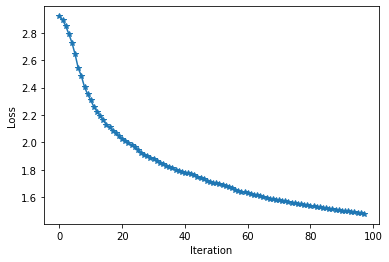

In [34]:
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.0005, n_batches=100, batch_size = 256)